In [34]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from diffusion import DiffusionModel, TargetType
from models import UNet
from google.colab import drive
drive.mount('/content/drive')

img_path = '/content/drive/MyDrive/sprites_1788_16x16.npy'
labels_path = '/content/drive/MyDrive/sprite_labels_nc_1788_16x16.npy'

images = np.load(img_path)
labels = np.load(labels_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
images, indicies = np.unique(images, return_index=True, axis=0)

In [36]:
labels = labels[indicies]

In [37]:
labels.shape

(1722, 5)

In [38]:
images.shape

(1722, 16, 16, 3)

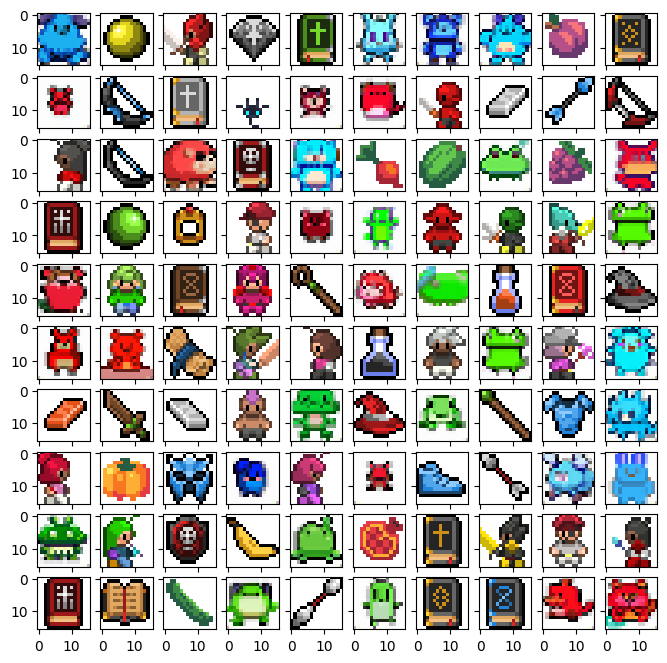

In [6]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(8, 8), \
                        sharey=True, sharex=True)

img_indicies = np.random.choice(range(0, len(images)), 100, replace=False)
for img, fig_x in zip(img_indicies, ax.flatten()):
    im_val = images[img]
    fig_x.imshow(im_val)
    fig_x.grid(False)

## Dataset exploration

In [39]:
labels = np.argmax(labels, axis=1)

In [8]:
import pandas as pd

unique_values, counts = np.unique(labels, return_counts=True)
frequency_dict = dict(zip(unique_values, counts))

pd.Series(frequency_dict)

0    120
1    642
2    120
3    680
4    160
dtype: int64

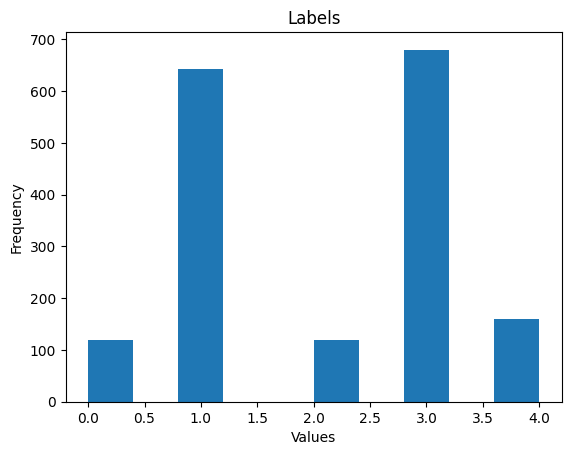

In [8]:
plt.hist(labels)

plt.title('Labels')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.show()

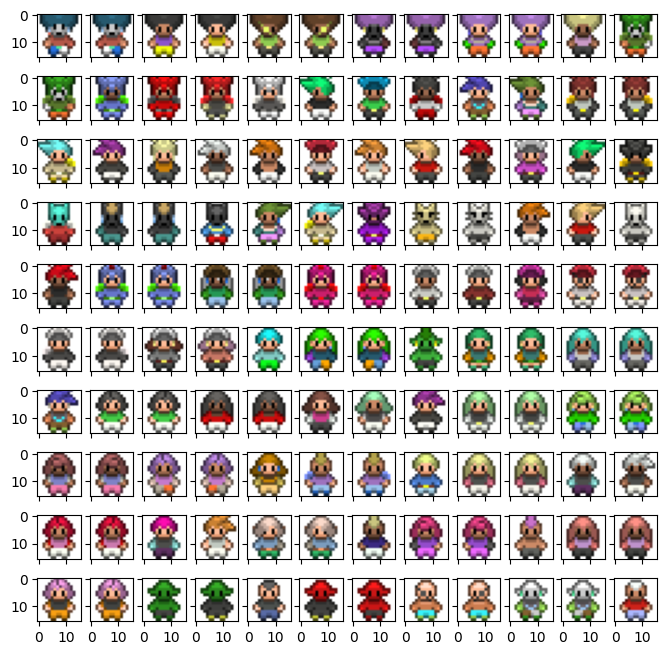

In [42]:
fig, ax = plt.subplots(nrows=10, ncols=12, figsize=(8, 8), \
                          sharey=True, sharex=True)

for img, fig_x in zip(images[labels == 0], ax.flatten()):
    im_val = img
    fig_x.imshow(im_val)
    fig_x.grid(False)

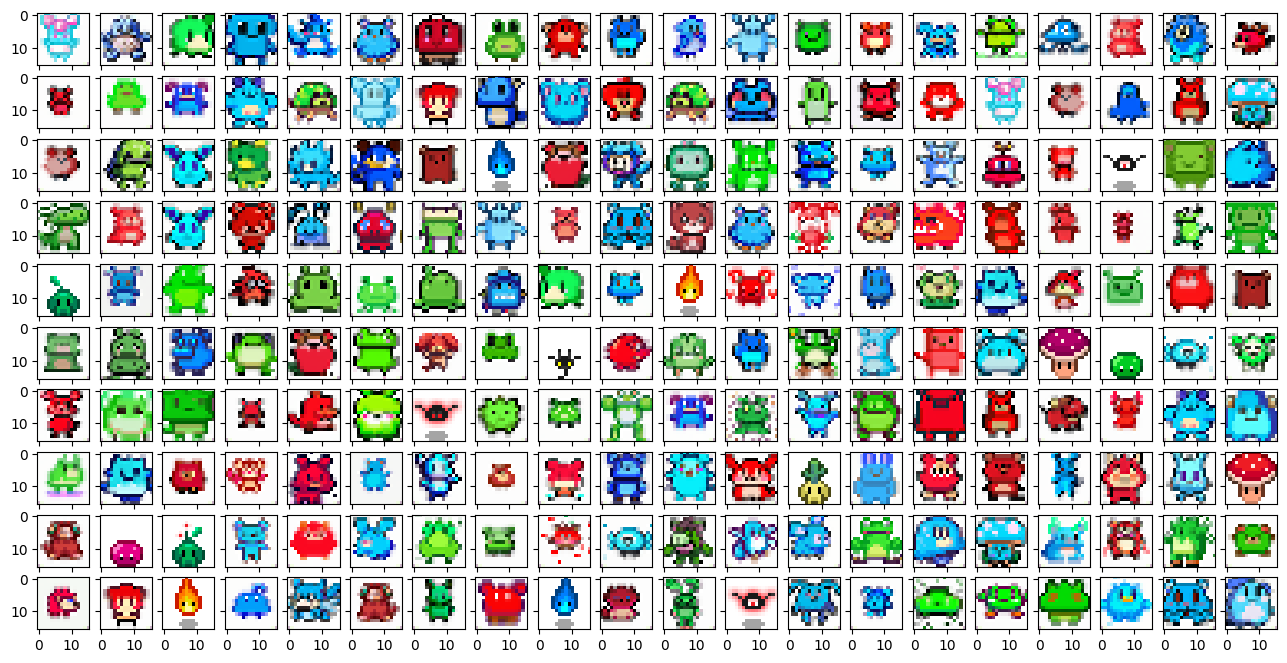

In [45]:
fig, ax = plt.subplots(nrows=10, ncols=20, figsize=(16, 8), \
                          sharey=True, sharex=True)

imgs = images[labels == 1]
indicies = np.random.choice(range(0, len(imgs)), 200, replace=False)

for i, fig_x in zip(indicies, ax.flatten()):
    fig_x.imshow(imgs[i])
    fig_x.grid(False)

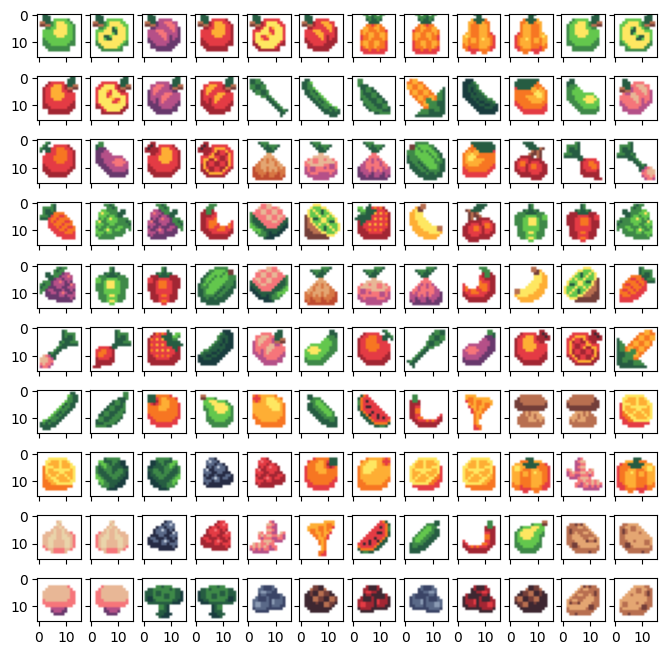

In [46]:
fig, ax = plt.subplots(nrows=10, ncols=12, figsize=(8, 8), \
                          sharey=True, sharex=True)

for img, fig_x in zip(images[labels == 2], ax.flatten()):
    im_val = img
    fig_x.imshow(im_val)
    fig_x.grid(False)

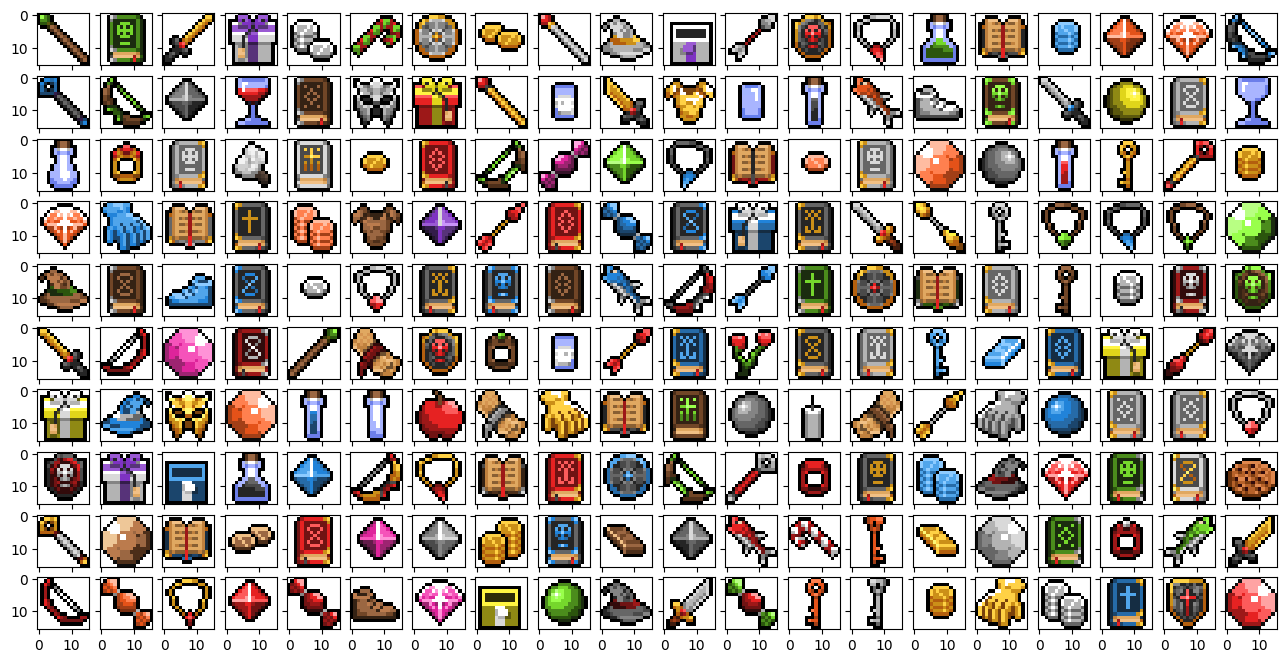

In [47]:
fig, ax = plt.subplots(nrows=10, ncols=20, figsize=(16, 8), \
                          sharey=True, sharex=True)

imgs = images[labels == 3]
indicies = np.random.choice(range(0, len(imgs)), 200, replace=False)

for i, fig_x in zip(indicies, ax.flatten()):
    fig_x.imshow(imgs[i])
    fig_x.grid(False)

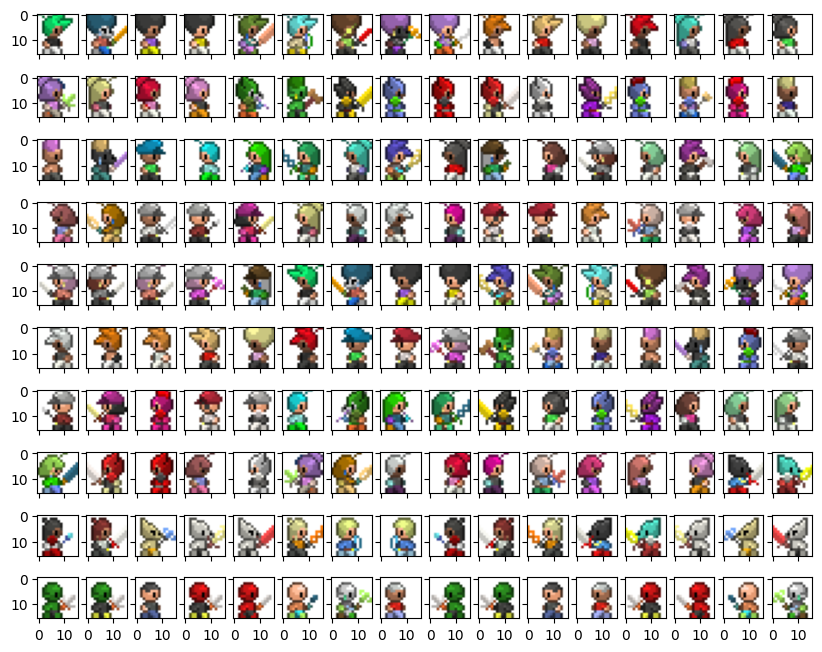

In [48]:
fig, ax = plt.subplots(nrows=10, ncols=16, figsize=(10, 8), \
                          sharey=True, sharex=True)

for img, fig_x in zip(images[labels == 4], ax.flatten()):
    im_val = img
    fig_x.imshow(im_val)
    fig_x.grid(False)

## Creating a dataset

In [129]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.data = (torch.Tensor(np.transpose(images, (0, 3, 1, 2)) / 255) - 0.5) * 2
        self.labels = torch.Tensor(labels.reshape(-1, 1)).long()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]

        if self.transform:
            image = self.transform(image)

        return image, self.labels[index]

In [145]:
from imblearn.over_sampling import RandomOverSampler

resampler = RandomOverSampler(sampling_strategy={0: 400, 1: 1200, 2: 400, 3: 800, 4: 400})
resampled_data, resampled_labels = resampler.fit_resample(images.reshape(len(labels), -1), labels)
resampled_dataset = ImageDataset(resampled_data.reshape(-1, 16, 16, 3), resampled_labels)

batch_size = 128
data_loader = torch.utils.data.DataLoader(resampled_dataset, batch_size=batch_size, shuffle=True)

In [146]:
len(resampled_dataset)

3200

In [133]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## DDPM predicting noise

In [173]:
n_steps = 1000

model = UNet(in_channels=3, out_channels=3, n_steps=n_steps).to(device)
diffusion_model = DiffusionModel(model, img_size=16, n_steps=n_steps)
n_epochs = 100
#losses = diffusion_model.train(n_epochs, data_loader, len(resampled_dataset))
diffusion_model.upload_weights("ddpm_noise_prediction.pt")

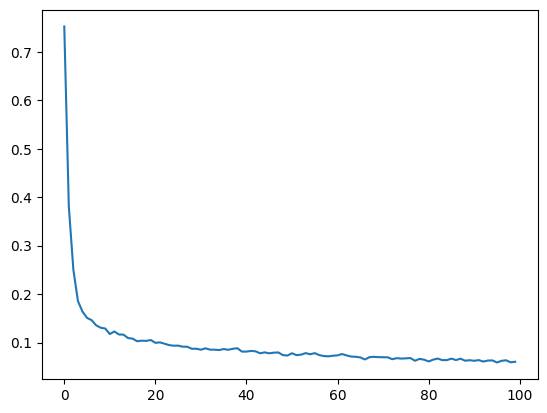

In [148]:
plt.plot(losses)

### Stohastic sampling

999it [00:15, 64.66it/s]


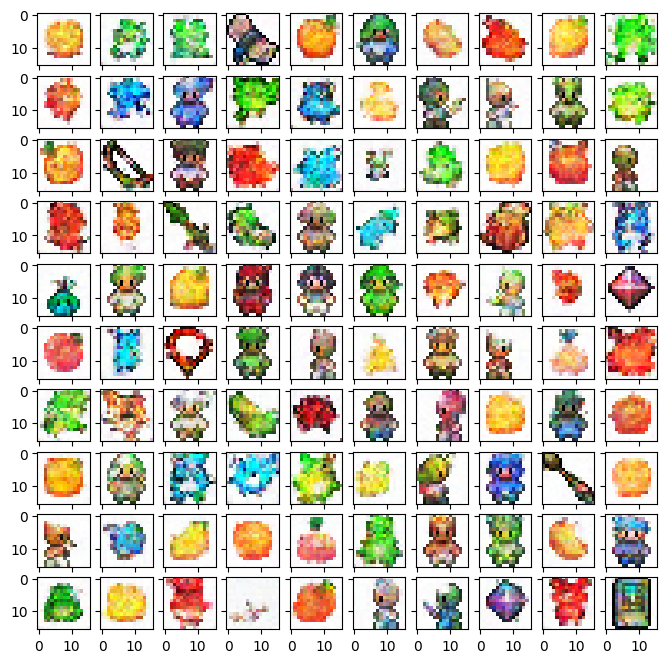

In [174]:
stohastic_images = diffusion_model.sample(100)
fig, ax = plt.subplots(nrows=10, ncols=10,figsize=(8, 8), \
                        sharey=True, sharex=True)

new_images = np.transpose(stohastic_images.to("cpu"), (0, 2, 3, 1))
for img, fig_x in zip(new_images, ax.flatten()):
    fig_x.imshow(img)
    fig_x.grid(False)

### Deterministic sampling

999it [00:15, 64.43it/s]


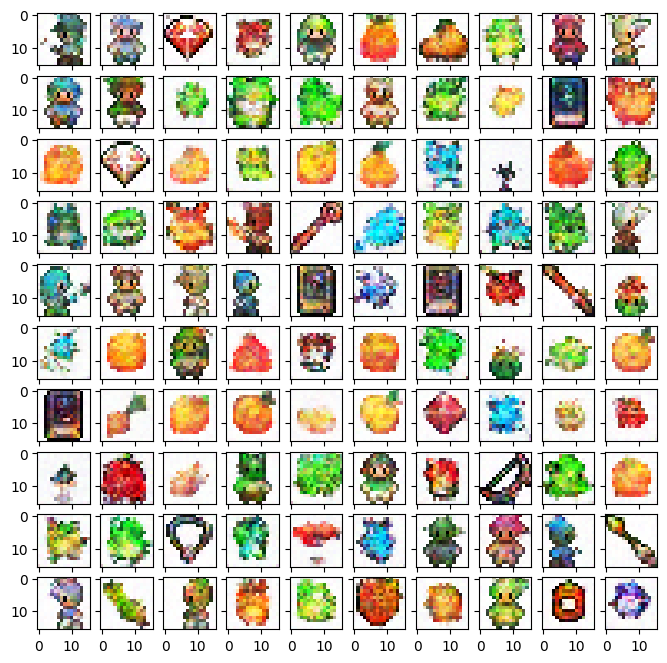

In [175]:
deterministic_images = diffusion_model.sample(100, eta=0)
fig, ax = plt.subplots(nrows=10, ncols=10,figsize=(8, 8), \
                        sharey=True, sharex=True)

new_images = np.transpose(deterministic_images.to("cpu"), (0, 2, 3, 1))
for img, fig_x in zip(new_images, ax.flatten()):
    fig_x.imshow(img)
    fig_x.grid(False)

### FID calculation

In [176]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(feature=64)

imgs_dist1 = torch.tensor(np.transpose(images, (0, 3, 1, 2)), dtype=torch.uint8)
imgs_dist2 = stohastic_images.to("cpu")

fid.update(imgs_dist1, real=True)
fid.update(imgs_dist2, real=False)
print("Stohastic sampling FID", fid.compute())

imgs_dist2 = deterministic_images.to("cpu")
fid.update(imgs_dist2, real=False)
print("Deterministic sampling FID", fid.compute())

Stohastic sampling FID tensor(0.9671)
Deterministic sampling FID tensor(0.8494)


In [153]:
diffusion_model.save_model("ddpm_noise_prediction.pt")

## DDPM predicting signal itself

In [166]:
n_steps = 500

model = UNet(in_channels=3, out_channels=3, n_steps=n_steps).to(device)
diffusion_model = DiffusionModel(model, img_size=16, n_steps=n_steps, model_type=TargetType.X_START)
n_epochs = 100
#diffusion_model.train(n_epochs, data_loader, len(resampled_dataset))
diffusion_model.upload_weights("ddpm_signal_prediction.pt")

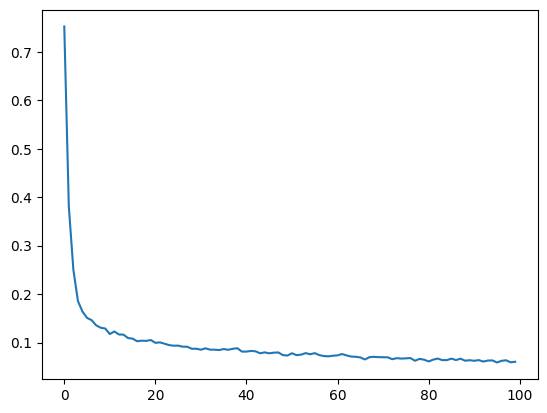

In [155]:
plt.plot(losses)

### Stohastic sampling

499it [00:07, 64.28it/s]


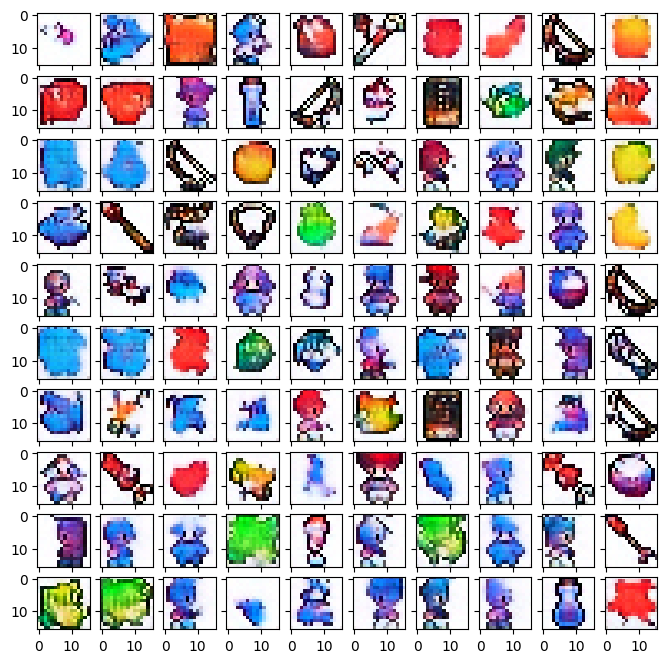

In [168]:
stohastic_images = diffusion_model.sample(100)
fig, ax = plt.subplots(nrows=10, ncols=10,figsize=(8, 8), \
                        sharey=True, sharex=True)

new_images = np.transpose(stohastic_images.to("cpu"), (0, 2, 3, 1))
for img, fig_x in zip(new_images, ax.flatten()):
    fig_x.imshow(img)
    fig_x.grid(False)

### Deterministic sampling

499it [00:07, 65.58it/s]


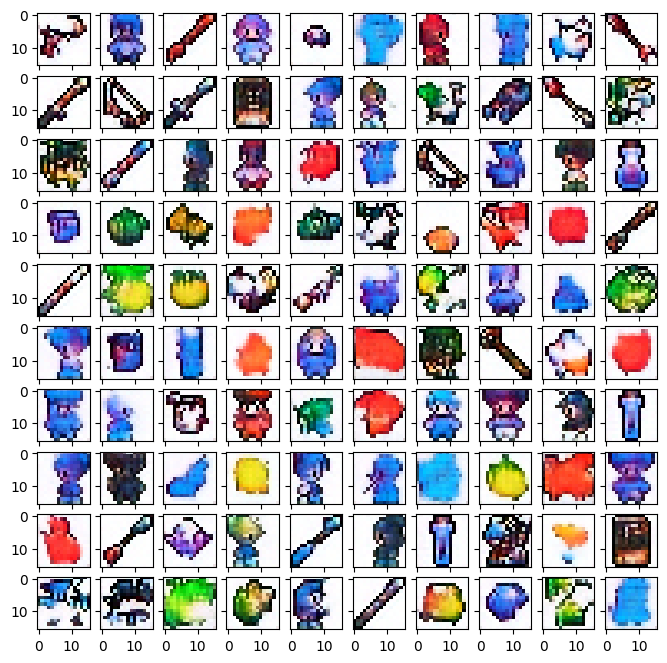

In [169]:
deterministic_images = diffusion_model.sample(100, eta=0)
fig, ax = plt.subplots(nrows=10, ncols=10,figsize=(8, 8), \
                        sharey=True, sharex=True)

new_images = np.transpose(deterministic_images.to("cpu"), (0, 2, 3, 1))
for img, fig_x in zip(new_images, ax.flatten()):
    fig_x.imshow(img)
    fig_x.grid(False)

### FID calculation

In [172]:
fid = FrechetInceptionDistance(feature=64)

imgs_dist2 = stohastic_images.to("cpu")

fid.update(imgs_dist1, real=True)
fid.update(imgs_dist2, real=False)
print("Stohastic sampling FID", fid.compute())

imgs_dist2 = deterministic_images.to("cpu")
fid.update(imgs_dist2, real=False)
print("Deterministic sampling FID", fid.compute())

Stohastic sampling FID tensor(0.9674)
Deterministic sampling FID tensor(0.8071)


In [75]:
diffusion_model.save_model("ddpm_signal_prediction.pt")

## Conditional ddpm

In [180]:
n_steps = 500

model = UNet(in_channels=3, out_channels=3, n_steps=n_steps, n_classes=5).to(device)
diffusion_model = DiffusionModel(model, img_size=16, n_steps=n_steps, is_conditioned=True)
n_epochs = 100
#losses = diffusion_model.train(n_epochs, data_loader, len(resampled_dataset))
diffusion_model.upload_weights("conditional_ddpm.pt")

In [78]:
target_labels = torch.Tensor([[0]] * 20 + [[1]] * 20 + [[2]] * 20 + [[3]] * 20 + [[4]] * 20).to(device).long()

499it [00:15, 32.38it/s]


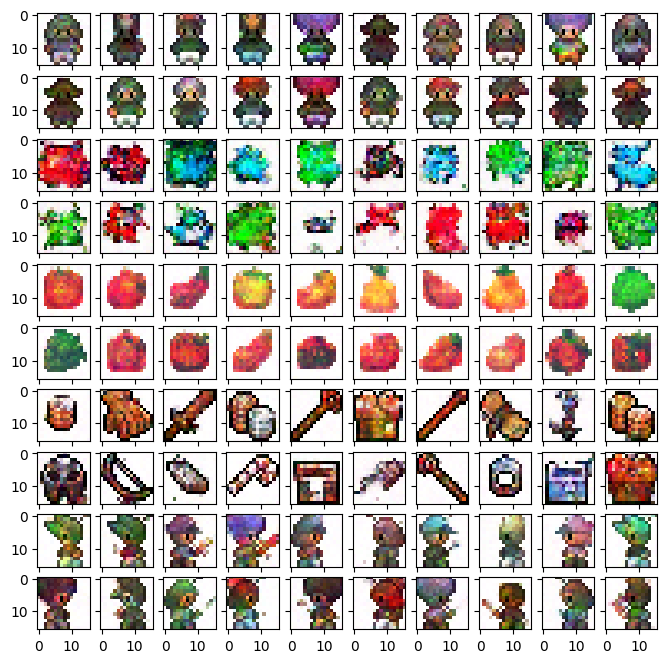

In [181]:
new_image = diffusion_model.sample(100, target_labels, eta=1, w=1)
fig, ax = plt.subplots(nrows=10, ncols=10,figsize=(8, 8), \
                        sharey=True, sharex=True)

new_images = np.transpose(new_image.to("cpu"), (0, 2, 3, 1))
for img, fig_x in zip(new_images, ax.flatten()):
    fig_x.imshow(img)
    fig_x.grid(False)

499it [00:15, 32.34it/s]


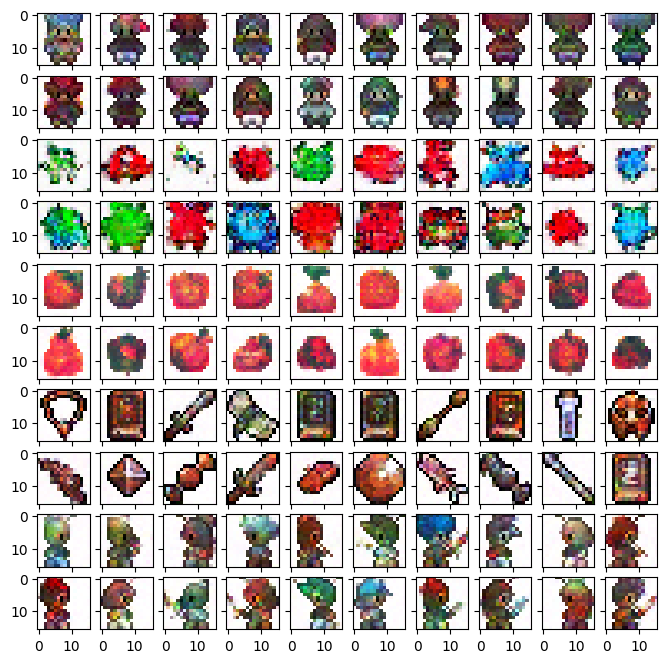

In [187]:
new_image = diffusion_model.sample(100, target_labels, eta=0, w=1.5)
fig, ax = plt.subplots(nrows=10, ncols=10,figsize=(8, 8), \
                        sharey=True, sharex=True)

new_images = np.transpose(new_image.to("cpu"), (0, 2, 3, 1))
for img, fig_x in zip(new_images, ax.flatten()):
    fig_x.imshow(img)
    fig_x.grid(False)

In [82]:
diffusion_model.save_model("conditional_ddpm.pt")